# 【例題2.8】

## (6) 洪水追跡計算
### ④Muskingum-Cunge法による洪水追跡計算プログラム

- Muskingum-Cunge法による洪水追跡計算を行います．

- 計算条件は，エクセルファイル”MCungeInput.xlsx”をご確認ください．
    - 計算条件の設定は，"計算条件"のシートで行います．
    - 上流端流量の設定は，"上流端流量の経時変化"のシートで行います．
    - 上流端流量ハイドログラフは，プログラム"Discharge/discharge.py"で作成します．

- 流量の経時変化が，"Muskigum.pdf"に出力されます．


In [10]:
"""Muskingum Cunge法により洪水追跡を行うプログラム."""
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 定数の設定
INPUT_FILE_NAME = "MCungeInput.xlsx"
OUTPUT_FILE_NAME = "Muskingum.xlsx"
SHEET1_NAME = "計算条件"
SHEET2_NAME = "上流端流量の経時変化"
FONTSIZE_XYLABEL = 14
Q_MIN = 0.0
Q_MAX = 2100.

## Muskingum-Cunge法のクラス
$
Q_{i+1}^{t+\Delta t} = C_1 Q_i^{t} + C_2 Q_i^{t+\Delta t} + C_3 Q_{i+1}^{t}
$

$C_1 = \frac{KX+0.5\Delta t}{K(1-X)+0.5\Delta t}$，
$C_2 = \frac{0.5\Delta t-KX}{K(1-X)+0.5\Delta t}$，
$C_3 = \frac{K(1-X)-0.5\Delta t}{K(1-X)+0.5\Delta t}$

$C_1+C_2+C_3 = 1$

$K=\frac{\Delta x}{\lambda}$，$X = 0.5-\frac{\mu}{\lambda \Delta x} (0 \le X \le 0.5)$


In [11]:
class Muskingum:
    """Muskingum-Cunge法のクラス."""

    def __init__(self):
        """初期設定."""
        self.data = pd.read_excel(INPUT_FILE_NAME, sheet_name=None)
        # 計算条件の読み込み
        print(self.data[SHEET1_NAME])
        __colName = self.data[SHEET1_NAME].columns
        self.K = self.data[SHEET1_NAME][__colName[1]][0]
        self.X = self.data[SHEET1_NAME][__colName[1]][1]
        self.dt = self.data[SHEET1_NAME][__colName[1]][2]
        self.xEnd = self.data[SHEET1_NAME][__colName[1]][3]
        self.dx = self.data[SHEET1_NAME][__colName[1]][4]
        # 上流端流量の読み込み
        print(self.data[SHEET2_NAME])
        __colName = self.data[SHEET2_NAME].columns
        self.tb = np.array(self.data[SHEET2_NAME][__colName[0]])  # 時刻
        self.Qb = np.array(self.data[SHEET2_NAME][__colName[1]])  # 流量
        # dt時間に応じたtbとQb
        __tmpdT = self.dt/3600.
        self.Q = self.Qb[self.tb % __tmpdT == 0.0]
        self.t = self.tb[self.tb % __tmpdT == 0.0]

    # 流量を計算する関数
    def __calcQ(self, _QI):
        _C1 = (.5*self.dt+self.K*self.X)/(self.K*(1.-self.X)+.5*self.dt)
        _C2 = (.5*self.dt-self.K*self.X)/(self.K*(1.-self.X)+.5*self.dt)
        _C3 = (self.K*(1.-self.X)-.5*self.dt)/(self.K*(1.-self.X)+.5*self.dt)
        _QO = np.copy(_QI)
        for i in range(len(_QO)-1):
            _QO[i+1] = _C1*_QI[i]+_C2*_QI[i+1]+_C3*_QO[i]
        return (_QO)

    def calcProc(self):
        """計算手順."""
        __N = int(self.xEnd/self.dx)
        __Q = []
        __x = []
        __Q.append(self.Q)
        for __i in range(__N):
            __x.append(self.dx*__i)
            __QO = self.__calcQ(__Q[__i])
            __Q.append(__QO)
        self.resQ = np.array(__Q)
        self.x = np.array(__x)

    def plot(self, _setDis):
        """グラフの出力."""
        plt.figure(figsize=(5., 2.5))
        plt.xlim(np.min(self.t), 48)
        plt.grid()
        _setDis = np.array(_setDis)

        for __x in _setDis:
            __i = np.where(self.x == __x)[0][0]
            plt.plot(self.t, self.resQ[__i], '-', label=str(__x)+"km")
        plt.legend(fontsize=FONTSIZE_XYLABEL, fancybox=False, framealpha=1)
        plt.ylim(Q_MIN, Q_MAX)
        plt.xlabel("$t$ (hr)", fontsize=FONTSIZE_XYLABEL)
        plt.ylabel("$Q$ (m$^3/s$)", fontsize=FONTSIZE_XYLABEL)
        plt.savefig("muskingum.pdf", transparent=True, bbox_inches='tight')
    
    def writeFile(self, _setDis):
        """ファイルへの出力."""
        __df = pd.DataFrame(self.t, columns=['t(hr)'])
        for __x in _setDis:
            __i = np.where(self.x == __x)[0][0]
            __colName =  str(__x)+"(km)"
            __df[__colName] = self.resQ[__i]
        # エクセルファイルへの書き出し
        __df.to_excel(OUTPUT_FILE_NAME, index=False)

# main関数

           変数名        数値
0            K  2887.200
1            X     0.241
2  時間の刻み幅dT(s)  7200.000
3     計算区間(km)   100.000
4    空間の刻幅(km)    10.000
         t(hr)  Q(m3/s)
0     0.000000    200.0
1     0.166667    200.0
2     0.333333    200.0
3     0.500000    200.0
4     0.666667    200.0
..         ...      ...
296  49.333333    200.0
297  49.500000    200.0
298  49.666667    200.0
299  49.833333    200.0
300  50.000000    200.0

[301 rows x 2 columns]


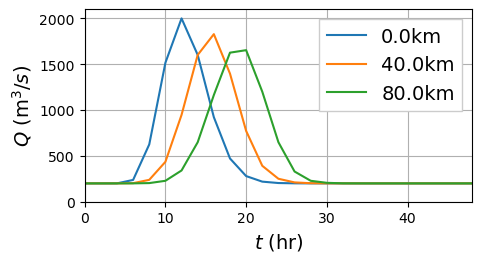

In [12]:
if __name__ == "__main__":
    """main関数"""
    muskingum = Muskingum()
    muskingum.calcProc()
    __setKP = [0.0, 40., 80.]
    muskingum.plot(__setKP)
    muskingum.writeFile(__setKP)